In [8]:
import pandas as pd
from textblob import TextBlob
import logging
import numpy as np
from numpy import random
import gensim
import nltk
import lxml
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

%matplotlib inline

ig = pd.read_csv("../dataset/tsv/event_ig_p5y.tsv", sep="\t")
searchfor = [" food "," eat "," makan "," steam "," boil "," ingredient "," roast "," chicken "," beef "," pork "," rice "," noodle "]
ig_food = ig[ig['post_caption'].str.contains('|'.join(searchfor), case=False, na=False)]
ig_food['sentiment'] = ig_food['post_caption'].apply(lambda tweet: TextBlob(tweet).sentiment)
print(ig_food['post_caption'].values[2], ig_food['sentiment'].values[2]) # to read post and their sentiments

/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Surprise to see food hanging on gate this morning.  Thank you to my sweet nice neighbour @anonymised_user  for yummy Raya breakfast.  Sentiment(polarity=0.475, subjectivity=0.825)


/var/folders/x1/zp6kq1kj15v_md17wpr_q_n40000gn/T/ipykernel_23872/1529438814.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_food['sentiment'] = ig_food['post_caption'].apply(lambda tweet: TextBlob(tweet).sentiment)


In [9]:
ig_food.head()

,user_id,user_name,post_id,post_shortcode,post_type,post_date,post_caption,post_tagged_users,post_hashtags,post_mentions,post_comments,post_likes,segment_name,sentiment
1,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,thick-curassow-of-stimulating-authority,2579202108475507200,CPLKqcHnwJx,image,2021-05-22 12:01:12,I start to play with all kinds of ingredients ...,NaN,NaN,NaN,1.0,18.0,Optimistic Providers,"(0.25, 0.75)"
11,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,portable-strict-hedgehog-from-saturn,2466869157390242304,CI8FG25nNLh,image,2020-12-18 12:15:41,Thank you @anonymised_user for the Advance Chr...,NaN,NaN,NaN,1.0,21.0,Optimistic Providers,"(-0.6, 0.95)"
27,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,busy-teal-wapiti-of-education,2315810443056404992,CAjaVQJhFka,image,2020-05-24 02:08:59,Surprise to see food hanging on gate this morn...,NaN,NaN,NaN,0.0,26.0,Optimistic Providers,"(0.475, 0.825)"
29,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,vague-esoteric-labrador-of-elegance,2282467869361281280,B-s9G8khZt-,image,2020-04-08 02:03:14,@anonymised_user DAY 1 : HBL home canteen foo...,NaN,NaN,NaN,1.0,18.0,Optimistic Providers,"(0.0, 0.0)"
60,7d47b5c439cc78762803f97b3a22f91ab411ab1ca05af4...,phenomenal-optimal-anteater-of-force,2503599011410180096,CK-kglHH3XI,image,2021-02-07 04:31:21,Love this rice bag bucket hat!!! Fits nicely i...,NaN,#vivicheosg|#cute|#ricebagcollection|#loveyour...,NaN,4.0,45.0,Optimistic Providers,"(0.5553125, 0.6599999999999999)"


In [10]:
ig_food.post_caption = ig_food.post_caption.astype('str')
ig_food = ig_food[ig_food['segment_name'].notna()]
ig_food['post_caption'].apply(lambda x: len(x.split(" "))).sum()

/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


2161946

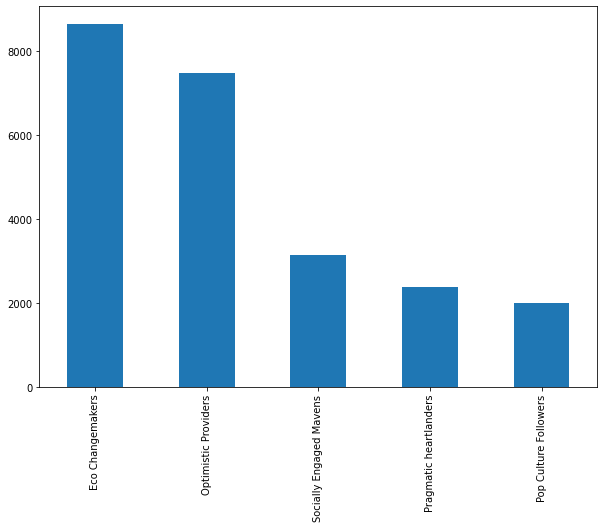

In [12]:
plt.figure(figsize=(10,7))
ig_food.segment_name.value_counts().plot(kind='bar');

(array([2.3476e+04, 7.1000e+01, 1.6000e+01, 7.0000e+00, 9.0000e+00,
        6.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  30.1,  60.2,  90.3, 120.4, 150.5, 180.6, 210.7, 240.8,
        270.9, 301. , 331.1, 361.2, 391.3, 421.4, 451.5, 481.6, 511.7,
        541.8, 571.9, 602. , 632.1, 662.2, 692.3, 722.4, 752.5, 782.6,
        812.7, 842.8, 872.9, 903. ]),
 <BarContainer object of 30 artists>)

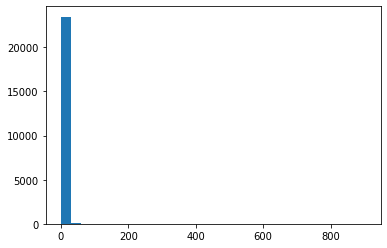

In [18]:
plt.hist(ig_food.post_comments[ig_food.post_comments <= 1000], bins=30)

# Using BERT

In [19]:
model_name = "bert-base-multilingual-uncased"
max_length = 512

In [20]:
from transformers import BertTokenizerFast

ModuleNotFoundError: No module named 'transformers'